<a href="https://colab.research.google.com/github/lmoghimi/personal-processing/blob/main/JSynchrotronRadiat_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Read me!
*   Please download this Colab notebook and add it to your Google Drive. Data is available at the following link and should be downloaded as well.
https://drive.google.com/drive/u/1/folders/1UPx2exhB2RwePGqRC3scFO-sBXupoMUF
*   Users will need to set the user directory (represented as the 'userdir' variable) in the Startup section, accordingly.
*   Files that are saved during this runtime are temporarily stored in the '/content/' section of your Google Drive. They will be deleted when the runtime is over.

---

# **Startup**

In [1]:
#@title imports for JupyterLite
%pip install -q ipywidgets

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import os
import glob

import numpy as np

import math
from math import log

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import pandas as pd

import csv

import tkinter as tk
from tkinter import filedialog

import scipy

import re #useful for splitting strings

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.5 MB/s eta 0:00:00


In [3]:
from google.colab import drive
mount_loc = '/content/drive'
drive.mount(mount_loc) #mount your Google Drive to access the files stored here.

Mounted at /content/drive


In [4]:
#@title global inputs

### directories ###
#users will want to personally define the directory that hosts this Python notebook. This should be the same directory that hosts the data files.
userdir = mount_loc +'/Shareddrives/Extraction_Subgroup_Data/NSLS-II_Methods_2025' #adjust as appropriate #os.getcwd()
print('userdir:',userdir)
refsdir = os.path.join(userdir,'phase_references')
laserpyromdir = os.path.join(userdir, 'laser_pyrometer_logs')
fe2o3_run_folder = os.path.join(userdir,'1D_integration_fe2o3')
wte2_run_folder = os.path.join(userdir,'1D_integration_wte2')

shift = True
get_timestamps = True

### plotting colors for the phases ###
lincol_fe='tab:purple' #iron
lincol_w='tab:pink' #wustite
lincol_m='tab:green' #magnetite
lincol_h='tab:cyan' #hematite

userdir: /content/drive/Shareddrives/Extraction_Subgroup_Data/NSLS-II_Methods_2025


# **Custom functions**

In [5]:
#@title foldername()
def foldername(file_name):
    '''
    returns the run folder when given a file name
    '''
    parsename = file_name.split('-')[0].split('_')
    #print('parsename =', parsename)
    #print('last element=', parsename[-1])
    parsename.remove(parsename[-1])
    #print('result is', '_'.join(parsename))

    run_folder = '_'.join(parsename)
    print('run_folder =', run_folder)
    return run_folder

In [6]:
#@title get_rawdata()
def get_rawdata(run_folder, file_name):
    '''
    Output: rawdata i.e. q and I
    '''
    run_path = os.path.join(userdir, 'tiff_base', run_folder, 'integration')
    print('run_path = ', run_path)
    file_path = os.path.join(run_path,file_name)
    print('file_path =', file_path)

    rawdata = np.loadtxt(file_path)
    print('rawdata has been loaded')
    return rawdata

In [7]:
#@title trapinteg()
'''
trapezoidal integration across a small region of q
'''
def trapinteg(q,I,a,b):
    #q, I is the dataset (x, y) and a, b are the left and right bounds for the integration
    idx_a = np.argmin(np.abs(q - a))
    idx_a = int(idx_a)
    # print('idx_a:',idx_a)
    idx_b = np.argmin(np.abs(q - b))
    idx_b = int(idx_b)
    # print('idx_b:',idx_b)

    q_tinyarray = q[idx_a:idx_b+1]
    I_tinyarray = I[idx_a:idx_b+1]

    n_intv = len(q_tinyarray) - 1 #number of intervals for the integration
    dq = (b - a)/n_intv
    # print('n_intv:',n_intv)
    # print('dq:',dq)

    integarea = scipy.integrate.trapezoid(I_tinyarray, q_tinyarray, dx=dq)

    return integarea, idx_a, idx_b

In [8]:
#@title process_pyrom_laser()
def process_pyrom_laser(fp):
    '''
    Reads the pyrometer data for a given input file and expresses data points relative to t0
    '''
    pyrom_data = pd.ExcelFile(fp)
    try:
        y_axis_pyrom = pyrom_data.parse('Sheet1')['eurotherm_T']
        x_axis_pyrom = pyrom_data.parse('Sheet1')['pyrometer_sec']
    except KeyError:
        print(f"Error: Column not found.")
        exit()

    laser_data = pd.ExcelFile(fp)
    try:
        y_axis_laser = laser_data.parse('Sheet1')['Power_W']
        x_axis_laser = laser_data.parse('Sheet1')['laser_sec']
    except KeyError:
        print(f"Error: Column not found.")
        exit()

    return x_axis_pyrom, y_axis_pyrom, x_axis_laser, y_axis_laser

In [9]:
#@title area_beneath_peak()
'''
area beneath the peak baseline
'''
def area_beneath_peak(q,I,a,b):
    #q, I is the dataset (x, y) and a, b are the left and right bounds for the integration
    idx_a = np.argmin(np.abs(q - a))
    idx_b = np.argmin(np.abs(q - b))

    q_tinyarray = q[idx_a:idx_b+1]
    I_tinyarray = I[idx_a:idx_b+1]

    # Perform linear interpolation
    baseline_interpolated = np.interp([q_tinyarray[0], q_tinyarray[-1]], [q_tinyarray[0], q_tinyarray[-1]], [I_tinyarray[0], I_tinyarray[-1]])
    # this is super not what I thought it was: baseline_interpolated = np.interp(q_tinyarray, q_tinyarray, I_tinyarray) #y_interpolated = np.interp(x_new, x_known, y_known)

    output = scipy.integrate.trapezoid(baseline_interpolated, q_tinyarray)

    return output

# **Load data for Fig. 4**




In [10]:
#@title read files and load into raw_data_save_all and bkgdsub_data_save_all

#which files to read?
run_folder = fe2o3_run_folder
print('run_folder:', run_folder)
filelist = glob.glob(run_folder + '/run10_H2_20250303-223943_6fc50f*')
# print('filelist:',filelist)
background_file = glob.glob(run_folder + '/run10_H2_20250303-225730_e1f439_primary-1_mean_q.chi')
print('background_file:', background_file)

#create filedict
filedict = {}
for filename in filelist:
    file_parse = os.path.basename(filename).split('_')
    # print(file_parse)
    if not ('tth.chi' in file_parse): #read only q-formatted data
        primary_number = file_parse[-3]
        # print('primary_number:',primary_number)
        filedict[primary_number] = filename

# print('\n filedict =', filedict)
print('number of files: ', len(filedict))
ntimestamps = len(filedict) #setting this to a smaller number will plot this many scans, equally spaced in time
print('ntimestamps (entered) =', ntimestamps)

#organize files chronologically and load data into the array raw_data_save_all
if get_timestamps:
    timestamps = ['primary-%d'%k for k in np.linspace(1, len(filedict), ntimestamps).astype(int)]
# print('timestamps:',timestamps)
primary = []
raw_data_save_all = []

for enum_index, timestamp in enumerate(timestamps):
    # print('enum_index:',enum_index)
    # print('timestamp:',timestamp)
    filename = filedict[timestamp]
    # print('Loading file...', os.path.basename(filename))
    timestamp_num = int(timestamp.split('-')[-1]) # convert "timestamp" string to number
    # print('Loading as scan #...', timestamp_num)

    rawdata = np.loadtxt(filename) #each rawdata is [(#data, 2)], where 2 represents q and I columns. q = rawdata[:, 0], I = rawdata[:, 1]
    raw_data_save_all.append(rawdata) #stacks the array  #makes 3D array of 125, q and I for each run --> (nstimestamps, nt, 2)
    primary.append(timestamp_num)

raw_data_save_all = np.array(raw_data_save_all)
print('shape of raw_data_save_all array is: ', raw_data_save_all.shape)

############################ background subtraction ##################################
rawbkgd = np.loadtxt(background_file[0])
bkgd_data = np.array(rawbkgd)

background = bkgd_data
q_bkgd = bkgd_data[:,0]
I_bkgd = bkgd_data[:,1]
bkgdsub_data_save_all = []
for iv, timestamp in enumerate(raw_data_save_all[:, 0, 0]):
    #print(iv)
    timestamp_num = iv+1
    rawdata = raw_data_save_all[iv, :, :]
    q = rawdata[:, 0]
    I = rawdata[:, 1]
    I_bkgdsub = I-I_bkgd
    bkgdsub_data_save_all.append(I_bkgdsub)

bkgdsub_data_save_all = np.array(bkgdsub_data_save_all)
print('shape of bkgdsub_data_save_all array is: ', bkgdsub_data_save_all.shape)

run_folder: /content/drive/Shareddrives/Extraction_Subgroup_Data/NSLS-II_Methods_2025/1D_integration_fe2o3
background_file: ['/content/drive/Shareddrives/Extraction_Subgroup_Data/NSLS-II_Methods_2025/1D_integration_fe2o3/run10_H2_20250303-225730_e1f439_primary-1_mean_q.chi']
number of files:  80
ntimestamps (entered) = 80
shape of raw_data_save_all array is:  (80, 3000, 2)
shape of bkgdsub_data_save_all array is:  (80, 3000)


# *Fig. 4a*




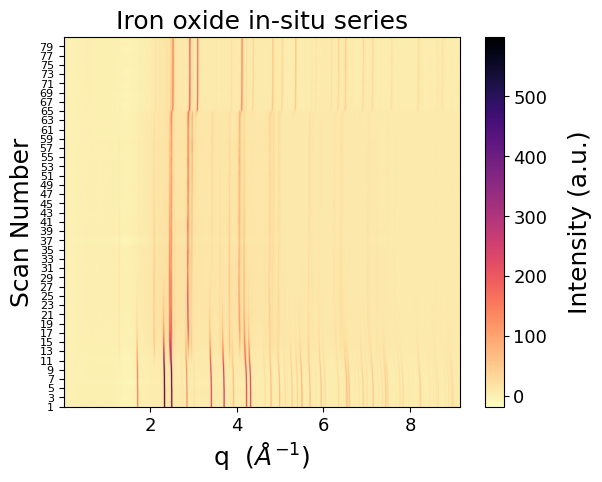

In [11]:
#@title iron oxide color map
q_values = raw_data_save_all[0, :, 0]  # q is in the first column
I_data = np.array([bkgdsub_data_save_all[i,:] for i in range(len(timestamps))]) #plot background-subtracted intensities

# create the intensity map
# fs = (6,10)
f, axes = plt.subplots(1, 1)
fontsz = 18
tickfontsz = 13
axes.set_title('Iron oxide in-situ series', fontsize=fontsz)
axes.set_xlabel(r'q  (${\AA}^{-1}$)', fontsize=fontsz)
axes.set_ylabel("Scan Number", fontsize=fontsz)
extent_for_series = [q_values.min(), q_values.max(), 0, len(timestamps)]

im = axes.imshow(I_data, extent=extent_for_series, cmap='magma_r', aspect='auto', origin='lower') #magma_r, plasma_r

### add tick marks and colorbar legend ###
y_ticks = np.arange(len(timestamps))
n = 2 #show tick for every nth scan
axes.set_yticks(y_ticks[::n])
axes.set_yticklabels([str(int(ts.split('-')[-1])) for ts in timestamps[::n]], fontsize = 8)  # Label with scan numbers. The corresponding time (in sec) is given in the pyrometer file
plt.xticks(fontsize=tickfontsz)

cbar = f.colorbar(im, ax=axes, location='right')
cbar.ax.tick_params(labelsize=tickfontsz)
cbar.set_label('Intensity (a.u.)', fontsize=fontsz, labelpad=15)

# *Fig. 4b*




In [12]:
#@title peak integration inputs: hematite
a1 = 2.28
b1 = 2.38
a2 = 2.25
b2 = 2.38
a3 = 2.26
b3 = 2.335

#defining the integration bounds (a, b) for each frame
a = []
b = []

for iv, timestamp in enumerate(raw_data_save_all[:, 0, 0]):
    frame = iv + 1
    # print('frame:',frame)
    if frame < 10:
        a.append(a1)
        b.append(b1)
    elif frame > 9 and frame < 20:
        a.append(a2)
        b.append(b2)
    elif frame > 19 and frame < 38:
        a.append(a3)
        b.append(b3)
    else:
        a.append(float('nan'))
        b.append(float('nan'))

a = np.array(a)
b = np.array(b)

In [14]:
#@title peak integration inputs: magnetite
a1 = 2.05
b1 = 2.13
a2 = 2.08
b2 = 2.15

#defining the integration bounds (a, b) for each frame
a = []
b = []

for iv, timestamp in enumerate(raw_data_save_all[:, 0, 0]):
    frame = iv + 1
    # print('frame:',frame)
    if frame > 9 and frame < 65:
        a.append(a1)
        b.append(b1)
    elif frame > 64:
        a.append(a2)
        b.append(b2)
    else:
        a.append(float('nan'))
        b.append(float('nan'))

a = np.array(a)
b = np.array(b)

In [16]:
#@title peak integration inputs: wustite
a1 = 4.005
b1 = 4.12
a2 = 4.05
b2 = 4.17

#defining the integration bounds (a, b) for each frame
a = []
b = []

for iv, timestamp in enumerate(raw_data_save_all[:, 0, 0]):
    frame = iv + 1
    # print('frame:',frame)
    if frame > 9 and frame < 65:
        a.append(a1)
        b.append(b1)
    elif frame > 64:
        a.append(a2)
        b.append(b2)
    else:
        a.append(float('nan'))
        b.append(float('nan'))

a = np.array(a)
b = np.array(b)

In [18]:
#@title peak integration inputs: iron
a1 = 3.02
b1 = 3.14

#defining the integration bounds (a, b) for each frame
a = []
b = []

for iv, timestamp in enumerate(raw_data_save_all[:, 0, 0]):
    frame = iv + 1
    # print('frame:',frame)
    if frame > 37: #or 49 --- doesn't make a difference
        a.append(a1)
        b.append(b1)
    else:
        a.append(float('nan'))
        b.append(float('nan'))

a = np.array(a)
b = np.array(b)

The peak integration cell below uses the input cell that was most recently executed.

In [19]:
#@title peak integration and save to file
pk1_integ_area = []
q_values = np.array([raw_data_save_all[i, :, 0] for i in range(len(timestamps))])
I_bkgdsubdata = np.array([bkgdsub_data_save_all[i, :] for i in range(len(timestamps))])


######## numeric integration for each scan #######
for iv, timestamp in enumerate(raw_data_save_all[:, 0, 0]):
    frame = iv + 1
    # print('frame:',frame)
    q = q_values[iv]
    I = I_bkgdsubdata[iv]


    if not math.isnan(a[iv]):
        tot_integarea, idx_a, idx_b = trapinteg(q,I,a[iv],b[iv])
        net_area = tot_integarea - area_beneath_peak(q,I,a[iv],b[iv])
    else:
        net_area = 0

    # print('net_area=',net_area)
    pk1_integ_area.append(net_area)

pk1_integ_area = np.array(pk1_integ_area)

### save to array ###
array_to_save = pk1_integ_area
df = pd.DataFrame(array_to_save)
save_location = '/content/pk1_integrated_area.csv' #'userdir/pk1_integrated_area.csv'
df.to_csv(save_location, index=False)
print('file saved to', save_location)

file saved to /content/pk1_integrated_area.csv


Rename pk1_integrated_area to h/w/m/fe_integrated_area as appropriate to proceed to the cell below. h/w/m/fe represent hematite, wustite, magnetite, and iron, respectively.

In [26]:
#@title read file and load into array
################### reading the find peaks data from the table #####################
peakfile = 'fe_integrated_area.csv' #@param ['h_integrated_area.csv','m_integrated_area.csv','w_integrated_area.csv','fe_integrated_area.csv']{allow-input: true}
integration_folderpath = '/content/' + peakfile #'userdir/' + peakfile
print('reading data from...'+integration_folderpath)
table_data = []
with open(integration_folderpath, mode = 'r') as file:
    csvFile = csv.DictReader(file)
    for lines in csvFile:
        # print(lines)
        # print(lines['0'])
        if len(lines['0']) > 0:
            # print("The string is not empty.")
            item = float(lines['0'])
        else:
            item = float('nan')
        table_data.append(item) #extract data from the file for python treatment

table_data = np.array(table_data)
# print('table_data:',table_data)

if peakfile == 'h_integrated_area.csv':
    h_integ_area = table_data
    print('loading into array...h_integ_area')
elif peakfile == 'm_integrated_area.csv':
    m_integ_area = table_data
    print('loading into array...m_integ_area')
elif peakfile == 'w_integrated_area.csv':
    w_integ_area = table_data
    print('loading into array...w_integ_area')
elif peakfile == 'fe_integrated_area.csv':
    fe_integ_area = table_data
    print('loading into array...fe_integ_area')

reading data from.../content/fe_integrated_area.csv
loading into array...fe_integ_area


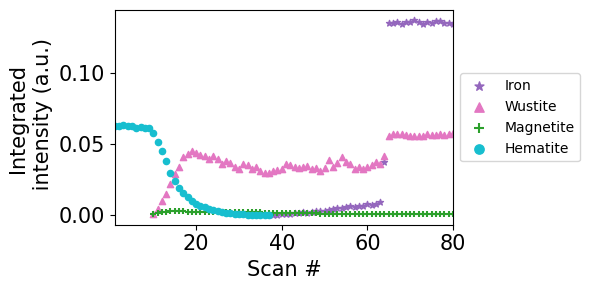

In [27]:
#@title plotting integrated itensity of phase peak vs. time

fig, ax = plt.subplots(figsize=(6,3), tight_layout=True) #(7,4), (6,6), (6,3)
thisfs = 15
markersz1 = 20
markersh = 'o'

F_h_104 = 217.4
F_m_q2 = 472.1
F_w_220 = 78.674
F_fe_110 = 35.3789

array1 = fe_integ_area
array2 = w_integ_area
array3 = m_integ_area
array4 = h_integ_area

### replacing zeros with nans ###
value_to_replace = 0
array1[array1 == value_to_replace] = np.nan
array2[array2 == value_to_replace] = np.nan
array3[array3 <= value_to_replace] = np.nan
array4[array4 <= value_to_replace] = np.nan
###                           ###

y1 = array1 / F_fe_110
y2 = array2 / F_w_220
y3 = array3 / F_m_q2
y4 = array4 / F_h_104

ax.scatter(primary, y1, color=lincol_fe, marker='*', s = markersz1, label='Iron')
ax.scatter(primary, y2, color=lincol_w, marker='^', s = markersz1, label='Wustite')
ax.scatter(primary, y3, color=lincol_m, marker='+', s = markersz1, label='Magnetite')
ax.scatter(primary, y4, color=lincol_h, marker='o', s = markersz1, label='Hematite')

plt.legend(bbox_to_anchor=(1, 0.5), loc='center left', fontsize=10, markerscale=1.5)
plt.xlim([primary[0],primary[-1]])
ax.set_xlabel('Scan #', fontsize=thisfs)
ax.set_ylabel('Integrated \n intensity (a.u.)', fontsize=thisfs)
ax.tick_params(axis='x', labelsize=thisfs)
ax.tick_params(axis='y', labelsize=thisfs)
plottit = 'Integrated intensity\nnormalized by F_hkl'
# ax.set_title(plottit, fontsize=thisfs)
plt.show()

# *Fig. 4c*




<>:21: SyntaxWarning: invalid escape sequence '\c'
<>:21: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipython-input-3652207250.py:21: SyntaxWarning: invalid escape sequence '\c'
  ax1.set_ylabel("Pyrometer T ($^\circ$C)", fontsize=fs)


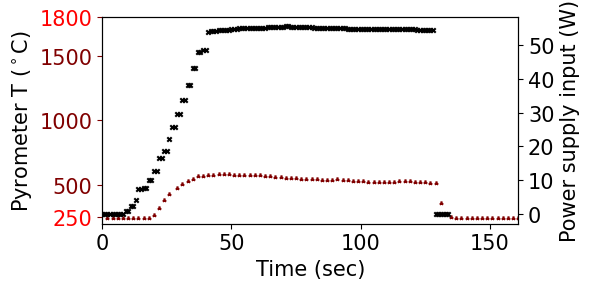

In [28]:
#@title laser and pyrometer outputs

### load the data ###
fp_combined_data = laserpyromdir + '/aligned_laser_pyrom_fe2o3.xlsx'
result = process_pyrom_laser(fp_combined_data)

######################## create the figure #######################
figsize = (6, 3)
fs = 15 #12
markersz = 10
col_pyrom = 'maroon'
col_pyrom_lim = 'r'
col_laser = 'k'
fig, ax1 = plt.subplots(figsize=figsize, tight_layout=True)

# plt.title('Hematite in H2 and IR environment', fontsize=fs)
ax1.set_xlabel("Time (sec)", fontsize=fs)
ax1.tick_params(axis='x', labelsize=fs)

#### pyrometer axis ####
ax1.set_ylabel("Pyrometer T ($^\circ$C)", fontsize=fs)
ax1.set_ylim(200, 1800)
ax1.set_yticks([250, 500, 1000, 1500, 1800])
ax1.tick_params(axis='y', labelsize=fs, colors=col_pyrom)
ax1.get_yticklabels()[0].set_color(col_pyrom_lim) #changing the color for 248C
ax1.get_yticklabels()[-1].set_color(col_pyrom_lim) #changing the color for 1800C

x_axis_pyrom = np.array(result[0], dtype='float32')
y_axis_pyrom = np.array(result[1], dtype='float32')
x_max_pyrom = np.nanmax(x_axis_pyrom)

ax1.scatter(x_axis_pyrom, y_axis_pyrom, marker = '2', s = markersz, c = col_pyrom) #pyrometer data

#### laser axis ###
ax2 = ax1.twinx()
ax2.set_ylabel('Power supply input (W)', fontsize=fs)
ax2.set_yticks([0, 10, 20, 30, 40, 50])
ax2.tick_params(axis='y', labelsize=fs, colors=col_laser)

x_axis_laser = np.array(result[2], dtype='float32')
y_axis_laser = np.array(result[3], dtype='float32')
x_max_laser = np.nanmax(x_axis_laser)

ax2.scatter(x_axis_laser, y_axis_laser, marker = 'x', s = markersz, c = col_laser) #laser log data

### set xlim and show plot ###
if x_max_laser > x_max_pyrom:
    x_max = x_max_laser
else:
    x_max = x_max_pyrom
# print('x_max_pyrom:',x_max_pyrom)
# print('x_max_laser:',x_max_laser)
# print('x_max:',x_max)
ax1.set_xlim(0, x_max)
plt.show()

# **Load data for Fig. 5**




In [24]:
#@title read files and load into raw_data_save_all

#which files to read?
run_folder = wte2_run_folder
print('run_folder:', run_folder)
filelist = glob.glob(run_folder + '/run80_bulksample_20240329-073328_31a7fa*')
# print('filelist:',filelist)

#create filedict
filedict = {}
for filename in filelist:
    file_parse = os.path.basename(filename).split('_')
    # print(file_parse)
    if not ('tth.chi' in file_parse): #read only q-formatted data
        primary_number = file_parse[-3]
        # print('primary_number:',primary_number)
        filedict[primary_number] = filename

# print('\n filedict =', filedict)
print('number of files: ', len(filedict))
ntimestamps = len(filedict) #setting this to a smaller number will plot this many scans, equally spaced in time
print('ntimestamps (entered) =', ntimestamps)

#organize files chronologically and load data into the array raw_data_save_all
if get_timestamps:
    timestamps = ['primary-%d'%k for k in np.linspace(1, len(filedict), ntimestamps).astype(int)]
# print('timestamps:',timestamps)
primary = []
raw_data_save_all = []

for enum_index, timestamp in enumerate(timestamps):
    # print('enum_index:',enum_index)
    # print('timestamp:',timestamp)
    filename = filedict[timestamp]
    # print('Loading file...', os.path.basename(filename))
    timestamp_num = int(timestamp.split('-')[-1]) # convert "timestamp" string to number
    # print('Loading as scan #...', timestamp_num)

    rawdata = np.loadtxt(filename) #each rawdata is [(#data, 2)], where 2 represents q and I columns. q = rawdata[:, 0], I = rawdata[:, 1]
    raw_data_save_all.append(rawdata) #stacks the array  #makes 3D array of 125, q and I for each run --> (nstimestamps, nt, 2)
    primary.append(timestamp_num)

raw_data_save_all = np.array(raw_data_save_all)
print('shape of raw_data_save_all array is: ', raw_data_save_all.shape)

run_folder: /content/drive/Shareddrives/Extraction_Subgroup_Data/NSLS-II_Methods_2025/1D_integration_wte2
number of files:  65
ntimestamps (entered) = 65
shape of raw_data_save_all array is:  (65, 3000, 2)


# *Fig. 5c*




shape of I_data: (65, 3000)
plotting from raw_data_save_all


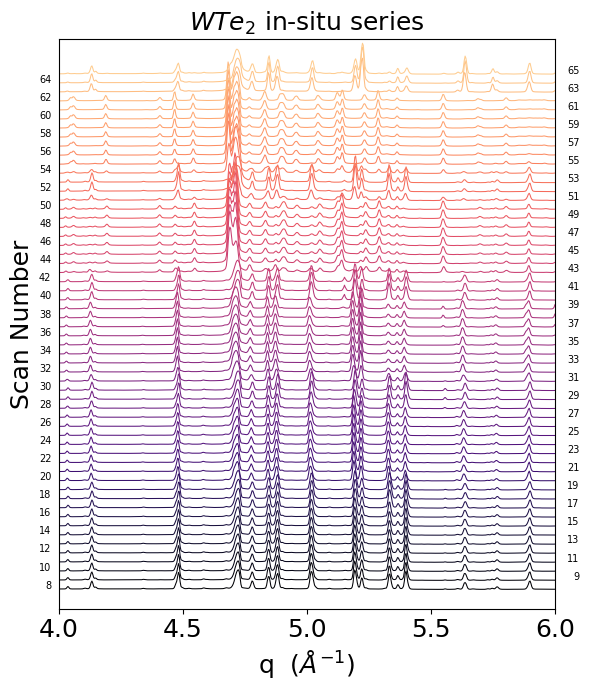

In [ ]:
# @title WTe2 waterfall plot
################# create figure object -- plotting settings ####################
figsize = (6, 7) #(12, 6)
fs = 18
line_label_fs = 7
lw = 0.75 #plotting linewidth
fig, ax = plt.subplots(1,1,figsize=figsize, tight_layout=True)

ax.set_xlabel(r'q  (${\AA}^{-1}$)', fontsize=fs)
ax.set_title('$WTe_2$ in-situ series', fontsize=fs)
ax.tick_params(labelsize=fs)
ax.tick_params(labelsize=fs)

wf_shift_coefficient = 100 #vertical shift between subsequent scans

################ plotting selected timestamps ###################################
q_values = np.array([raw_data_save_all[i, :, 0] for i in range(len(timestamps))])
I_data = np.array([raw_data_save_all[i, :, 1] for i in range(len(timestamps))])
print('shape of I_data:',np.shape(I_data))
n, m = np.shape(I_data)
num_of_lines = n #number of timestamps that will be plotted
lincol_gradient = iter(cm.magma(np.linspace(0,1,num_of_lines))) #the data evolution is most visible using wistia, copper, and autumn gradients
find_peak_outputs = []

print('plotting from raw_data_save_all')
for iv, timestamp in enumerate(raw_data_save_all[:, 0, 0]):
    # print(iv)
    if iv > 6:
        timestamp_num = iv+1
        rawdata = raw_data_save_all[iv, :, :]
        q = rawdata[:, 0]
        I_plot = rawdata[:, 1]

        ############## plot waterfall data ######################
        c=next(lincol_gradient)
        wf_shift = iv*wf_shift_coefficient
        ax.plot(q, I_plot+ wf_shift, color = c, linewidth = lw)
        if iv % 2 != 0:
            # print("The scan number is odd")
            ax.text(4-.03, I_plot[-1]+ wf_shift, timestamp_num, ha='right', va='bottom', fontsize = line_label_fs)
        else:
            # print("The scan number is even")
            ax.text(6+.1, I_plot[-1]+ wf_shift, timestamp_num, ha='right', va='bottom', fontsize = line_label_fs)

ax.set_xlim(4,6) #(-0.5,plot_save_max_q+1)
ax.set_ylim(500,6800)
plt.yticks([])
ax.set_ylabel("Scan Number", fontsize=fs) # the scan number is matched to time
ax.yaxis.set_label_coords(-0.05, 0.5)